In [1]:
import pandas as pd
import konlpy
import gensim
import tensorflow as tf

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)
print(tf.__version__)

1.3.3
0.5.2
4.1.2
2.6.0


## 1) 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 결측 데이터 확인
print(train_data.isnull().any(axis = 0))
print(test_data.isnull().any(axis = 0))

id          False
document     True
label       False
dtype: bool
id          False
document     True
label       False
dtype: bool


양쪽 모두 document에 결측데이터가 있음을 확인함 -> 결측 데이터 제거

In [4]:
# 중복 데이터 확인
train_data.duplicated(subset=['document']).sum(), test_data.duplicated(subset=['document']).sum()

(3817, 842)

In [5]:
train_data[train_data.duplicated(subset=['document'])]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149919,6502490,짱,1
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,1,0


중복데이터가 많음을 확인하였다. -> 중복데이터 중 처음것만 남김

## 2) 데이터로더 구성

In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 및 결측 데이터 처리
    train_data = train_data.drop_duplicates(subset=['document'])
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.drop_duplicates(subset=['document'])
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화 (형태소 추출)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화 (형태소 추출)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [1] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, train_data['label'].values, X_test, test_data['label'].values, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
len(X_train), y_train.shape, len(X_test), y_test.shape

(146182, (146182,), 49157, (49157,))

In [8]:
# word_to_index에서 index_to_word도 만들어줌.
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  16.96940191154864
문장길이 최대 :  117
문장길이 표준편차 :  12.843571191092


In [11]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens) * 100}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  42
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [13]:
X_train.shape, X_test.shape

((146182, 42), (49157, 42))

In [14]:
# X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
#                                                         value=word_to_index["<PAD>"],
#                                                         padding='post',
#                                                         maxlen=maxlen)

# X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
#                                                        value=word_to_index["<PAD>"],
#                                                        padding='post',
#                                                        maxlen=maxlen)

## 4) 모델 구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [15]:
vocab_size = 10000
word_vector_dim = 16

In [16]:
# LSTM 1 + Dense 2

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim))
model1.add(tf.keras.layers.LSTM(12))   
model1.add(tf.keras.layers.Dense(12, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 12)                1392      
_________________________________________________________________
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 161,561
Trainable params: 161,561
Non-trainable params: 0
_________________________________________________________________


In [17]:
# using conv-1d

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
# only using global max pooling

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [19]:
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X_train, y_train, random_state=42)

In [20]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 5) 모델 훈련 개시

In [23]:
epochs = 20

In [24]:
history1 = model1.fit(X,
                    y,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results1 = model1.evaluate(X_test,  y_test, verbose=2)

Epoch 1/20
215/215 [==============================] - 33s 8ms/step - loss: 0.5616 - accuracy: 0.7373 - val_loss: 0.4503 - val_accuracy: 0.8380
Epoch 2/20
215/215 [==============================] - 1s 6ms/step - loss: 0.3759 - accuracy: 0.8499 - val_loss: 0.3627 - val_accuracy: 0.8457
Epoch 3/20
215/215 [==============================] - 1s 6ms/step - loss: 0.3232 - accuracy: 0.8671 - val_loss: 0.3560 - val_accuracy: 0.8481
Epoch 4/20
215/215 [==============================] - 1s 6ms/step - loss: 0.3045 - accuracy: 0.8759 - val_loss: 0.3560 - val_accuracy: 0.8466
Epoch 5/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2907 - accuracy: 0.8830 - val_loss: 0.3550 - val_accuracy: 0.8481
Epoch 6/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2789 - accuracy: 0.8886 - val_loss: 0.3549 - val_accuracy: 0.8480
Epoch 7/20
215/215 [==============================] - 1s 6ms/step - loss: 0.2671 - accuracy: 0.8945 - val_loss: 0.3638 - val_accuracy: 0.8481
Epoch

In [25]:
history2 = model2.fit(X,
                    y,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results2 = model2.evaluate(X_test,  y_test, verbose=2)

Epoch 1/20
215/215 [==============================] - 19s 7ms/step - loss: 0.5233 - accuracy: 0.7424 - val_loss: 0.3810 - val_accuracy: 0.8298
Epoch 2/20
215/215 [==============================] - 1s 5ms/step - loss: 0.3462 - accuracy: 0.8496 - val_loss: 0.3594 - val_accuracy: 0.8418
Epoch 3/20
215/215 [==============================] - 1s 5ms/step - loss: 0.3105 - accuracy: 0.8685 - val_loss: 0.3582 - val_accuracy: 0.8425
Epoch 4/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2835 - accuracy: 0.8823 - val_loss: 0.3627 - val_accuracy: 0.8424
Epoch 5/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2558 - accuracy: 0.8966 - val_loss: 0.3738 - val_accuracy: 0.8414
Epoch 6/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2276 - accuracy: 0.9104 - val_loss: 0.3931 - val_accuracy: 0.8381
Epoch 7/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1986 - accuracy: 0.9249 - val_loss: 0.4188 - val_accuracy: 0.8335
Epoch

In [26]:
history3 = model3.fit(X,
                    y,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results3 = model3.evaluate(X_test,  y_test, verbose=2)

Epoch 1/20
215/215 [==============================] - 1s 4ms/step - loss: 0.5980 - accuracy: 0.7597 - val_loss: 0.4458 - val_accuracy: 0.8192
Epoch 2/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3824 - accuracy: 0.8374 - val_loss: 0.3669 - val_accuracy: 0.8397
Epoch 3/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3279 - accuracy: 0.8615 - val_loss: 0.3556 - val_accuracy: 0.8450
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2990 - accuracy: 0.8757 - val_loss: 0.3542 - val_accuracy: 0.8469
Epoch 5/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2774 - accuracy: 0.8863 - val_loss: 0.3585 - val_accuracy: 0.8462
Epoch 6/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2600 - accuracy: 0.8944 - val_loss: 0.3648 - val_accuracy: 0.8460
Epoch 7/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2446 - accuracy: 0.9017 - val_loss: 0.3748 - val_accuracy: 0.8434
Epoch 

## 6) Loss, Accuracy 그래프 시각화

In [28]:
import matplotlib.pyplot as plt

# 손실과 정확도를 그래프로 그려본다
def show_loss_and_accuracy_graph(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.subplots(2, 1, figsize=(5,8))
    
    plt.subplot(211)
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(212)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

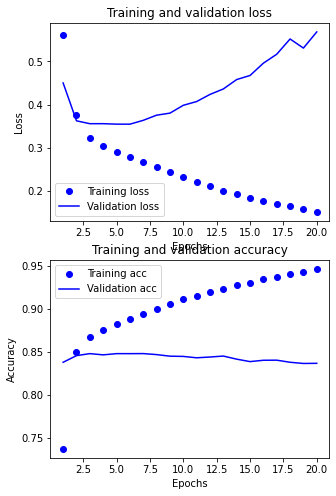

In [29]:
show_loss_and_accuracy_graph(history1)

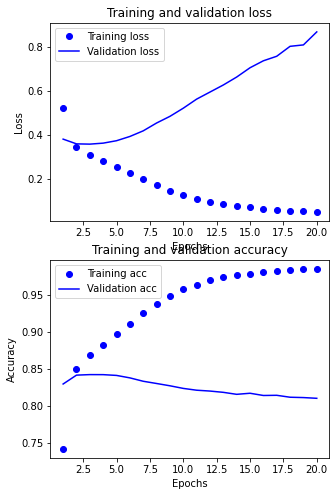

In [30]:
show_loss_and_accuracy_graph(history2)

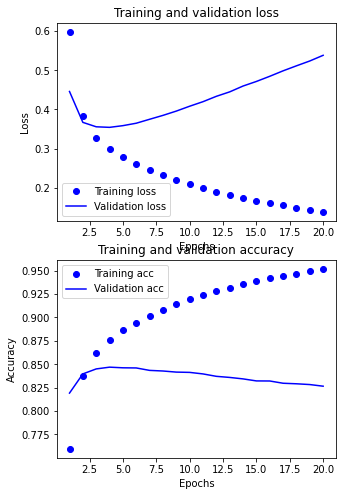

In [31]:
show_loss_and_accuracy_graph(history3)

3회정도 이후에는 traing loss와 validation loss간의 간격이 벌어지고 accuracy 벌어지는것이 확인됨.(과적합 발생)
따라서 20회까지 돌릴 필요가 없고 epoch을 줄여주는것이 현명 할 듯. 추후에는 4~5까지 줄 일 예정

## 7) 학습된 Embedding 레이어 분석

In [32]:
import os

# 첫번째 모델의 임베딩 레이어를 가져와서 분석
embedding_layer = model1.layers[0]
embedding_vectors = embedding_layer.get_weights()[0]
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim)) 
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(embedding_vectors[i, :])))))
f.close()

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors


word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("최고")

[('원작자', 0.9737907648086548),
 ('어떤지', 0.9681253433227539),
 ('그럼에도', 0.9673286080360413),
 ('게이트', 0.9667692184448242),
 ('-)', 0.9664754867553711),
 ('아랫', 0.9657061696052551),
 ('프랭크', 0.9651712775230408),
 ('호불호', 0.9613417387008667),
 ('맷데이먼', 0.9605461955070496),
 ('명작', 0.9596567153930664)]

딱히 임베딩이 뜻을 잘 담는지 의문임.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

```
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
```

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec = Word2VecKeyedVectors.load(
    os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model',
).wv

In [35]:
vector = word2vec['컴퓨터']
vector.shape 

(100,)

In [37]:
word2vec.similar_by_word("최고")

[('역대', 0.6544249653816223),
 ('최다', 0.6139797568321228),
 ('최악', 0.6104292273521423),
 ('최대', 0.6001774072647095),
 ('최저', 0.5936914682388306),
 ('정상급', 0.5868951082229614),
 ('올해', 0.5790539383888245),
 ('우수', 0.5667292475700378),
 ('최고령', 0.5547829866409302),
 ('최초', 0.5517786741256714)]

In [38]:
word2vec.similar_by_word("컴퓨터")

[('하드웨어', 0.806628942489624),
 ('소프트웨어', 0.7847487330436707),
 ('컴퓨팅', 0.7836830019950867),
 ('노트북', 0.7603618502616882),
 ('가상현실', 0.7591529488563538),
 ('그래픽스', 0.7564041614532471),
 ('메인프레임', 0.7557739019393921),
 ('PC', 0.7514778971672058),
 ('인공지능', 0.7492970824241638),
 ('프린터', 0.7475006580352783)]

사전 학습된 한국어 word2vec은 상당히 의미를 잘 담고 있는것으로 보인다.

In [59]:
from tensorflow.keras.initializers import Constant

word2vec_dim = 100

def init_embedding_matrix(vocab_size, word_dim):
    embedding_matrix = np.random.rand(vocab_size, word2vec_dim)
    for i in range(4,vocab_size):
        if index_to_word[i] in word2vec:
            embedding_matrix[i] = word2vec[index_to_word[i]]
    return Constant(embedding_matrix)

In [62]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                word2vec_dim, 
                embeddings_initializer=init_embedding_matrix(vocab_size, word2vec_dim),
                input_length=maxlen, 
                trainable=True))
model.add(tf.keras.layers.LSTM(64))   
# model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X,
                    y,
                    epochs=5,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 42, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,042,305
Trainable params: 1,042,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1714/1714 [==============================] - 12s 6ms/step - loss: 0.4216 - accuracy: 0.8032 - val_loss: 0.3481 - val_accuracy: 0.8487
Epoch 2/5
1714/1714 [==============================] - 10s 6ms/step - loss: 0.3146 - accuracy: 0.8643 - val_loss: 0.3262 - val_accuracy: 0.8565
Epoch 3/5
1714/1714 [==============================] - 9s 5ms/step - loss: 0.2748 - ac

total loss: 0.3366	accuracy: 0.861


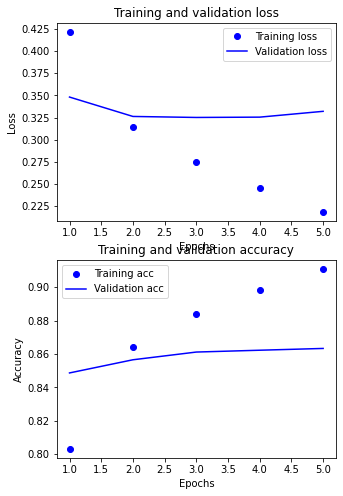

In [63]:
print(f"total loss: {results[0]:.4f}\taccuracy: {results[1]:.3f}")
show_loss_and_accuracy_graph(history)

목표기준이였던 85프로를 훌쩍~? 뛰어넘는 86프로 달성하였다 미션 성공!!

## 평가기준
- Text classification 3가지 이상의 모델이 성공적으로 시도됨
- gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
- 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

회고록 : 어려운 과제였지만, 좋은 코더를 만나서 수월하게 과제를 수행 할 수 있었습니다.
전처리 과정에서 Mecab을 통해 형태소 단위로 쪼갠 문자들을 가지고 마음대로 직접 만든 불용어 리스트 등을 만들고, 결측치와 중복 데이터 삭제를 하는 과정들이 저의 손길이 닿은 모델이 나오는 것 같아서 신기한 기분이었습니다.
또한 과제의 평가 기준을 위해 노력하면서 여러 하이퍼 파라미터들을 수정하면서 모델에 대한 이해도도 높일 수 있었습니다.